This notebook takes 1 March - 31 October. It uses 4 weeks of data to predict the next 2 weeks

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pandas import read_csv
import matplotlib.pyplot
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import date, timedelta
from sklearn.metrics import r2_score

In [2]:
cases = pd.read_csv("time_series_covid19_confirmed_US.csv")
deaths  = pd.read_csv("time_series_covid19_deaths_US.csv")
density = pd.read_csv("popden.csv")

In [3]:
fips = cases[(cases['10/31/20']<10000)]
fips = fips[(fips['10/31/20']>1000)]

f = fips['FIPS'].tolist()
cases = cases[cases['FIPS'].isin(f)]
deaths = deaths[deaths['FIPS'].isin(f)]

In [4]:
density.drop_duplicates(subset=['fips'],keep='last',inplace=True)

strings = {'NMR','PR','VI','KSC','NYC'}
index_names = density[(density['fips']).isin(strings)].index
density.drop(index_names, inplace=True)

density['fips']=density['fips'].astype(float)

In [5]:
c = pd.merge(cases,density, left_on='FIPS',right_on='fips')
d = pd.merge(deaths,density, left_on='FIPS',right_on='fips')

In [6]:
col = {'UID','iso2','iso3','code3','FIPS','Admin2','Province_State','Country_Region','Lat','Long_','Combined_Key','date','county','state','fips','cases','deaths','stay_at_home_announced','stay_at_home_effective','lat','lon','total_population','area_sqmi'}
c.drop(c.columns[c.columns.isin(col)],axis=1,inplace=True)
d.drop(d.columns[d.columns.isin(col)],axis=1,inplace=True)

In [7]:
from sklearn.preprocessing import minmax_scale
d['population_density_per_sqmi']=minmax_scale(d['population_density_per_sqmi'])
c['population_density_per_sqmi']=minmax_scale(c['population_density_per_sqmi'])

In [8]:
c

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,population_density_per_sqmi
0,0,0,0,0,0,0,0,0,0,0,...,6038,6050,6071,6079,6092,6117,6121,6143,6172,0.008940
1,0,0,0,0,0,0,0,0,0,0,...,19176,19267,19324,19361,19392,19433,19461,19554,19635,0.012209
2,0,0,0,0,0,0,0,0,0,0,...,2055,2053,2057,2061,2067,2070,2074,2084,2095,0.002726
3,0,0,0,0,0,0,0,0,0,0,...,5987,5997,6008,6021,6040,6042,6043,6058,6072,0.008631
4,0,0,0,0,0,0,0,0,0,0,...,1910,1924,1930,1934,1938,1940,1945,1948,1951,0.002332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0,0,0,0,0,0,0,0,0,0,...,3867,3871,3871,3880,3880,3887,3893,3892,3893,0.000617
1033,0,0,0,0,0,0,0,0,0,0,...,4639,4643,4643,4646,4646,4647,4649,4652,4655,0.000740
1034,0,0,0,0,0,0,0,0,0,0,...,4718,4743,4754,4764,4764,4792,4810,4816,4825,0.000177
1035,0,0,0,0,0,0,0,0,0,0,...,8098,8109,8116,8122,8122,8126,8135,8141,8145,0.003306


In [9]:
cases.fillna(0,inplace=True)
deaths.fillna(0,inplace=True)

deaths_results_MAE = np.zeros(15)
cases_results_MAE = np.zeros(15)

deaths_results_RMSE = np.zeros(15)
cases_results_RMSE = np.zeros(15)

deaths_score = np.zeros(15)
cases_score = np.zeros(15)

In [10]:
testx = {'population_density_per_sqmi'}
for i in range(1,29):
    s = '12/'+str(i)+'/20'
    testx.add(s)
testy = {'12/29/20'}
for i in range(30,32):
    s = '12/'+str(i)+'/20'
    testy.add(s)
for i in range(1,12):
    s = '1/'+str(i)+'/21'
    testy.add(s)

In [11]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {x_date.strftime("%-m/%-d/%y")}
    for i in range(1,28):
        s = x_date + timedelta(days=i)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    X_train =deaths.filter(x_days)
    y_train = deaths.filter(y_days)
    
    X_test = deaths.filter(testx)
    y_test = deaths.filter(testy)
    
    
    #X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    deaths_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    deaths_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int))
    deaths_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

/root/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
deaths_results_RMSE

array([7.74545755e+05, 6.25626317e+03, 3.84255992e+03, 8.72625525e+02,
       7.31631957e+02, 1.57886188e+03, 1.64586723e+03, 7.74682668e+02,
       8.42689777e+02, 1.63581598e+03, 4.61565403e+02, 1.28651997e+03,
       1.30450961e+03, 1.44213920e+03, 9.56532634e+02])

In [13]:
deaths_results_MAE

array([403.57237644,  46.94346649,  33.34691943,  14.7761002 ,
        13.96222072,  23.70765064,  22.98436019,  14.64881517,
        16.16858497,  23.57102234,  12.03297224,  21.30128639,
        20.87197021,  22.13039946,  17.82999323])

In [14]:
deaths_score

array([-59.86892257,   0.51329274,   0.70988031,   0.93545832,
         0.94512537,   0.88060879,   0.8763144 ,   0.94230539,
         0.93762487,   0.87580753,   0.9661549 ,   0.90336228,
         0.90199883,   0.89175707,   0.92824768])

In [15]:
x_date = date(2020,3,1)
y_date = date(2020,3,29)
delta = timedelta(days=14)

for j in range (0,15):
    
    x_days = {x_date.strftime("%-m/%-d/%y")}
    for i in range(1,28):
        s = x_date + timedelta(days=i)
        x_days.add(s.strftime("%-m/%-d/%y"))
    y_days = {y_date.strftime("%-m/%-d/%y")}
    for i in range(1,14):
        s = y_date + timedelta(days=i)
        y_days.add(s.strftime("%-m/%-d/%y"))
       
    X_train = cases.filter(x_days)
    y_train = cases.filter(y_days)
    
    X_test = cases.filter(testx)
    y_test = cases.filter(testy)
    
    #X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=42)
    reg = MLPRegressor(random_state=1, max_iter=1500).fit(X_train,y_train)
    cases_results_MAE[j]=mean_absolute_error(y_test.astype(int),reg.predict(X_test).astype(int))
    cases_results_RMSE[j]=mean_squared_error(y_test.astype(int),reg.predict(X_test).astype(int))
    cases_score[j] = r2_score(y_test,reg.predict(X_test))
    x_date += delta
    y_date += delta

In [16]:
cases_results_MAE

array([21354.85321598,  2151.6098172 ,  1268.07027759,   983.16736628,
        1502.88984428,  1121.22566012,  1451.48510494,  1300.12153013,
         725.68849018,  1335.94062288,   841.06289777,  1483.90656737,
        1366.57677725,  1515.25883548,  1312.02058226])

In [17]:
cases_results_RMSE

array([1.39528051e+09, 9.72705904e+06, 3.69578036e+06, 2.59056003e+06,
       4.38268139e+06, 2.62258520e+06, 4.32028493e+06, 3.59612649e+06,
       1.46826464e+06, 3.82187446e+06, 1.57028315e+06, 4.24398075e+06,
       3.77558974e+06, 4.59615402e+06, 3.54938228e+06])

In [18]:
cases_score

array([-47.78997426,   0.66963482,   0.8759063 ,   0.9161301 ,
         0.85292508,   0.91223095,   0.85647065,   0.87933048,
         0.9528111 ,   0.8721048 ,   0.94849844,   0.85795159,
         0.87432541,   0.84626768,   0.88123666])

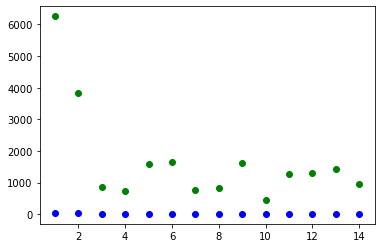

In [21]:
x_axis = np.arange(0,15)
plt.plot(x_axis[1:],deaths_results_MAE[1:],'bo')
plt.plot(x_axis[1:],deaths_results_RMSE[1:],'go')
#plt.plot(x_axis,deaths_results_MAE*len(x),'ro')

NameError: name 'x' is not defined

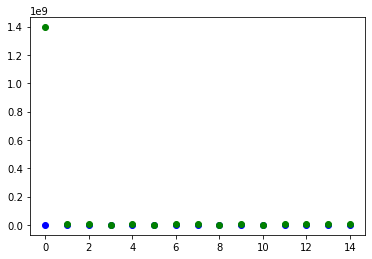

In [20]:
plt.plot(x_axis,cases_results_MAE,'bo')
plt.plot(x_axis,cases_results_RMSE,'go')
plt.plot(x_axis,cases_results_MAE*len(x),'ro')

In [ ]:
plt.plot(x_axis,cases_score,'yo')
plt.plot(x_axis,deaths_score,'ko')